# RNA Sequence Analysis Notebook

### Adv. Machine Learning Methods

### Cray Minor (A15863773)




### Goals
- featureCounts matrix input
- PCA
- differential expression
- Autoencoder to predict class
- add GSEA pipeline in later work

### 1) Package/Data loading & preprocessing

**import statements**

In [1]:
#regular imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#pydeseq2 for differential expression & statistics
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

#gseapy for gsea
import gseapy as gp
from gseapy.plot import gseaplot

#scanpy for pca
import scanpy as sc

#sklearn libraries
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

#sanbomics for mapping 'Geneid'
from sanbomics.tools import id_map
from sanbomics.plots import volcano

#keras for transfer learning
from keras.layers import Dense, Flatten

#tf for autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential

2023-06-18 15:11:21.353747: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**load data and set geneid to index, display count matrix columns**

In [2]:
ctrl_1 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_1.txt', sep = '\t', header = 1)
ctrl_1 = ctrl_1.set_index('Geneid')
print(ctrl_1.columns)

Index(['Chr', 'Start', 'End', 'Strand', 'Length',
       'sorted_aligned_reads_1.bam'],
      dtype='object')


In [3]:
ctrl_2 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_2.txt', sep = '\t', header = 1)
ctrl_2 = ctrl_2.set_index('Geneid')
print(ctrl_2.shape)

(56953, 6)


**load in control sample counts matricies**

In [4]:
ctrl_3 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_3.txt', sep = '\t', header = 1)
ctrl_3 = ctrl_3.set_index('Geneid')

ctrl_4 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_4.txt', sep = '\t', header = 1)
ctrl_4 = ctrl_4.set_index('Geneid')

ctrl_5 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_5.txt', sep = '\t', header = 1)
ctrl_5 = ctrl_5.set_index('Geneid')

ctrl_6 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_6.txt', sep = '\t', header = 1)
ctrl_6 = ctrl_6.set_index('Geneid')

ctrl_7 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_7.txt', sep = '\t', header = 1)
ctrl_7 = ctrl_7.set_index('Geneid')

ctrl_8 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_8.txt', sep = '\t', header = 1)
ctrl_8 = ctrl_8.set_index('Geneid')

ctrl_9 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_9.txt', sep = '\t', header = 1)
ctrl_9 = ctrl_9.set_index('Geneid')

**load in experimental counts matrix**

In [5]:
exp_1 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_10.txt', sep = '\t', header = 1)
exp_1 = exp_1.set_index('Geneid')

exp_2 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_11.txt', sep = '\t', header = 1)
exp_2 = exp_2.set_index('Geneid')

exp_3 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_12.txt', sep = '\t', header = 1)
exp_3 = exp_3.set_index('Geneid')

exp_4 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_13.txt', sep = '\t', header = 1)
exp_4 = exp_4.set_index('Geneid')

exp_5 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_14.txt', sep = '\t', header = 1)
exp_5 = exp_5.set_index('Geneid')

exp_6 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_15.txt', sep = '\t', header = 1)
exp_6 = exp_6.set_index('Geneid')

exp_7 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_16.txt', sep = '\t', header = 1)
exp_7 = exp_7.set_index('Geneid')

exp_8 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_17.txt', sep = '\t', header = 1)
exp_8 = exp_8.set_index('Geneid')

exp_9 = pd.read_csv('/Users/cray_minor/Desktop/kw_rna/counts_mats/counts_18.txt', sep = '\t', header = 1)
exp_9 = exp_9.set_index('Geneid')

**rename Length to lower-case, to concatenate df's, drop 'Chr' , 'Start' , 'End' , 'Strand' , 'Length' columns and keep the bam_values. the one renamed lower 'length' column will be used for TPM normalization** 
- basic data quality check
- TPM suggested normalization method for the data by laboratory colleague
- transcripts per million normalization, using bam_values
- function later in notebook
- unfiltered data used for autoencoder pred

In [6]:
ctrl_1 = ctrl_1.rename(columns={'Length': 'length'})

column = ctrl_1['sorted_aligned_reads_1.bam']
nonzero_count = (column != 0).sum()

max_value = ctrl_1['sorted_aligned_reads_1.bam'].max()

print("Maximum value:", max_value)
print("Number of non-zero values: ", nonzero_count)

Maximum value: 434878
Number of non-zero values:  12199


**keep bam_val and one 'length' column**

In [7]:
all_counts = pd.concat([ctrl_1, ctrl_2, ctrl_3, ctrl_4, ctrl_5, ctrl_6, ctrl_7, ctrl_8, ctrl_9,
                        exp_1, exp_2, exp_3, exp_4, exp_5, exp_6, exp_7, exp_8, exp_9], axis=1)

columns_to_drop = ['Chr', 'Start', 'End', 'Strand', 'Length']
all_counts = all_counts.drop(columns=columns_to_drop)

In [8]:
all_counts.columns = ['length', 'ctrl_1', 'ctrl_2', 'ctrl_3', 'ctrl_4', 'ctrl_5', 'ctrl_6', 'ctrl_7', 'ctrl_8', 'ctrl_9',
                      'exp_1', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9']

In [9]:
all_counts.shape

(56953, 19)

### 2) keras auto-encoder network

**create copy of dataset for auto encoder sample prediction task**
- create df copy, drop length leaving only counts
- transpose so that sample is index, 'Geneid' set to columns
- drop any rows that contain all zeros

In [10]:
auto_enc = all_counts.copy()
auto_enc.drop('length', axis=1, inplace=True)
auto_enc = auto_enc.T
auto_enc = auto_enc.loc[~(auto_enc == 0).all(axis=1)]

**encode ground truth label, control (0), experimental (1)**

In [11]:
y = pd.Series(auto_enc.index).apply(lambda x: 0 if x.startswith('ctrl') else 1)
print(y)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
dtype: int64


In [41]:
X_train, X_test, y_train, y_test = train_test_split(auto_enc, y, test_size=0.2, random_state=42)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(56953,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
test_loss, test_acc = model.evaluate(X_test, y_test)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
test_acc = accuracy_score(y_test, y_pred)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Accuracy:", test_acc)

Epoch 1/10
1/1 [==============================] - 1s 646ms/step - loss: 938.7259 - accuracy: 0.6429
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 8460.0859 - accuracy: 0.3571
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 3523.9050 - accuracy: 0.3571
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 765.9692 - accuracy: 0.6429
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 1561.8195 - accuracy: 0.6429
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 1307.4127 - accuracy: 0.6429
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 680.7436 - accuracy: 0.6429
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 728.4643 - accuracy: 0.3571
Epoch 10/10
1/1 [==============================] - 0s 60ms/step
Test Loss: 0.0
Test Accuracy: 1.0
Test

Epoch 1/10
1/1 [==============================] - 0s 134ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 376.6415 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 80ms/step - loss: 147.2524 - accuracy: 0.6429 - val_loss: 640.2713 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 85ms/step - loss: 242.3736 - accuracy: 0.6429 - val_loss: 298.9093 - val_accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - 0s 90ms/step - loss: 101.8530 - accuracy: 0.7857 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 85ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 100ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e

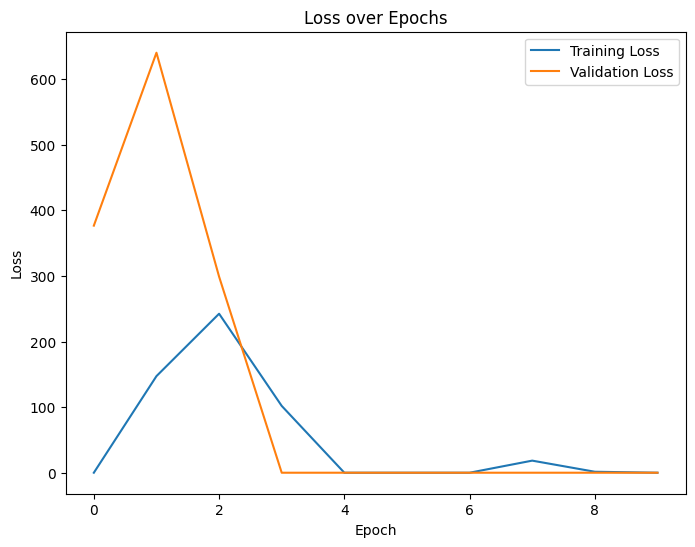

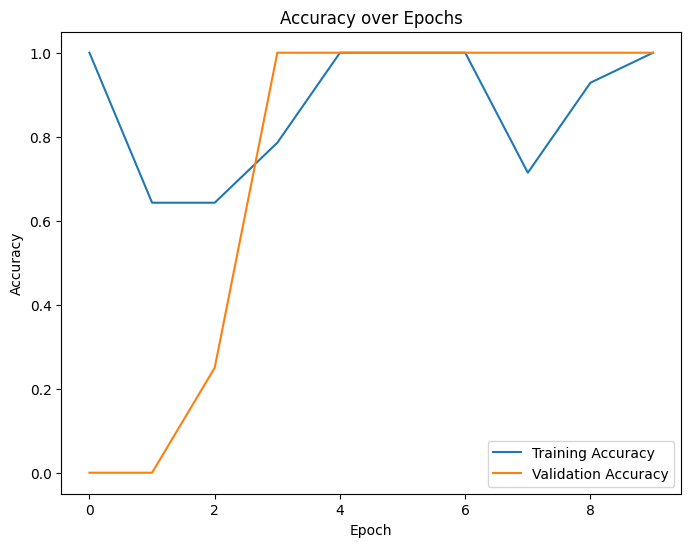

In [42]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

### 3) TPM normalization & pre-process

- normalize by gene length
- determine scaling factor
- normalize for sequence depth
- check gene level tpm's
- Zeros in all columns
- Keep in mind specific genes for further analysis (macros)

In [14]:
def read_counts2tpm(df):
    result = df
    sample_reads = result.loc[:, result.columns != 'length'].copy()
    gene_len = result.loc[:, ['length']]
    normalize_by_genelength = sample_reads.values / gene_len.values
    scaling_factor = (np.sum(normalize_by_genelength, axis=0).reshape(1, -1))/1e6
    normalize_sequencingdepth = normalize_by_genelength / scaling_factor
    tpm = normalize_sequencingdepth
    return tpm

**create data copy**

In [15]:
tpm_norm = pd.DataFrame(read_counts2tpm(all_counts))
tpm_norm.index = all_counts.index
tpm_norm.columns = all_counts.columns[1:]

**check shape, still need more preprocessing**

In [16]:
tpm_norm.shape

(56953, 18)

**check tpm normalization was done correctly does sum = 1,000,000**

In [17]:
tpm_norm.sum(axis = 0, skipna = True)

ctrl_1    1000000.0
ctrl_2    1000000.0
ctrl_3    1000000.0
ctrl_4    1000000.0
ctrl_5    1000000.0
ctrl_6    1000000.0
ctrl_7    1000000.0
ctrl_8    1000000.0
ctrl_9    1000000.0
exp_1     1000000.0
exp_2     1000000.0
exp_3     1000000.0
exp_4     1000000.0
exp_5     1000000.0
exp_6     1000000.0
exp_7     1000000.0
exp_8     1000000.0
exp_9     1000000.0
dtype: float64

**drop tpm 0 counts**

In [18]:
tpm_norm = tpm_norm.loc[~(tpm_norm == 0).all(axis=1)]
tpm_norm.shape

(20620, 18)

**PCA by condition, using tpm normed counts, using sklearn and matplotlib**

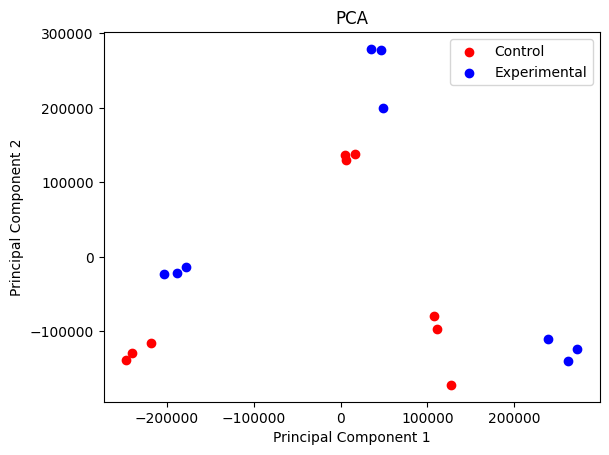

In [19]:
pca = PCA(n_components=3) #3 components best dimensionality reduction for data
pca_result = pca.fit_transform(auto_enc) 

ctrl_indices = np.arange(0, 9)  
exp_indices = np.arange(9, 18) 
ctrl_samples = pca_result[ctrl_indices]
exp_samples = pca_result[exp_indices] 

plt.scatter(ctrl_samples[:, 0], ctrl_samples[:, 1], c='red', label='Control')
plt.scatter(exp_samples[:, 0], exp_samples[:, 1], c='blue', label='Experimental')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.legend()
plt.show()

In [20]:
df = all_counts.copy()
df = df.drop(columns= ['length'])
df = df.loc[~(df == 0).all(axis=1)]
print(df.shape)

(20620, 18)


In [21]:
df.dtypes

ctrl_1    int64
ctrl_2    int64
ctrl_3    int64
ctrl_4    int64
ctrl_5    int64
ctrl_6    int64
ctrl_7    int64
ctrl_8    int64
ctrl_9    int64
exp_1     int64
exp_2     int64
exp_3     int64
exp_4     int64
exp_5     int64
exp_6     int64
exp_7     int64
exp_8     int64
exp_9     int64
dtype: object

**change gene index to gene_1 ... gene_n to keep ensmbl id's private**

In [22]:
gene_names = [f'gene_{i+1}' for i in range(len(df.index))]
df.index = gene_names
df = df.T
df.head(3)

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_20611,gene_20612,gene_20613,gene_20614,gene_20615,gene_20616,gene_20617,gene_20618,gene_20619,gene_20620
ctrl_1,0,0,5,3,0,0,101,0,0,89,...,10,39,59,5,4,10435,22806,6584,24313,401
ctrl_2,0,0,5,6,0,1,103,0,0,81,...,9,48,169,0,4,11156,24238,7165,24379,344
ctrl_3,2,0,5,0,0,0,95,0,0,81,...,8,25,54,4,3,9679,21756,6405,21486,373


### 3) PCA validation and further analysis (scanpy)

**create metadata for pydeseq2 package conditions**

In [23]:
metadata_df = pd.DataFrame(zip(df.index,['C','C','C','C','C','C','C','C','C','Exp','Exp','Exp','Exp','Exp','Exp','Exp','Exp','Exp']),
                        columns = ['Sample', 'Condition'])
metadata_df = metadata_df.set_index('Sample')
metadata_df

,Condition
Sample,
ctrl_1,C
ctrl_2,C
ctrl_3,C
ctrl_4,C
ctrl_5,C
ctrl_6,C
ctrl_7,C
ctrl_8,C
ctrl_9,C


In [24]:
dds_df = DeseqDataSet(
    counts=df,
    clinical=metadata_df,
    design_factors="Condition",
    refit_cooks=True,
    n_cpus=8,
)

**validate PCA plots, with second implmentation and further break down**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


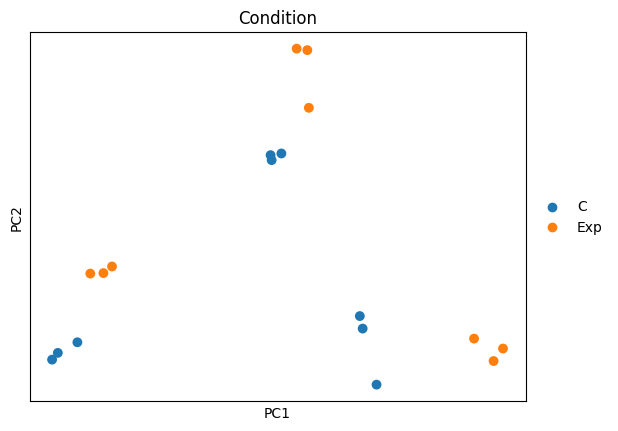

In [25]:
sc.tl.pca(dds_df)
sc.pl.pca(dds_df, color = 'Condition', size = 200)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


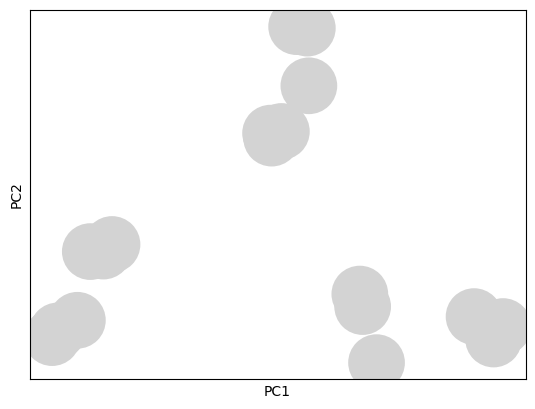

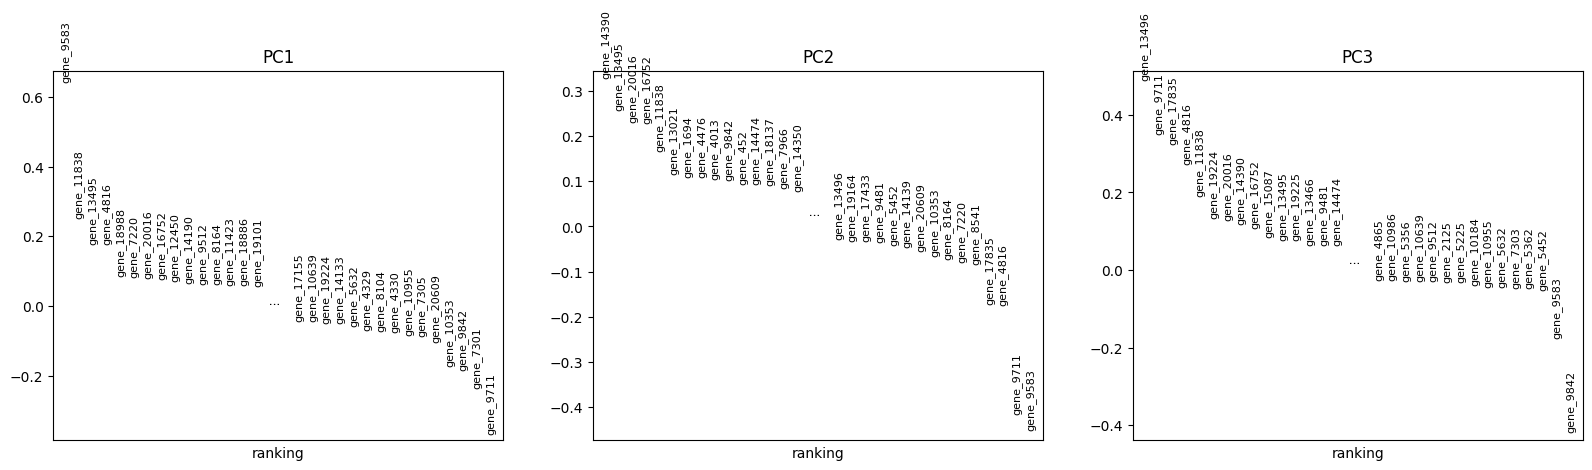

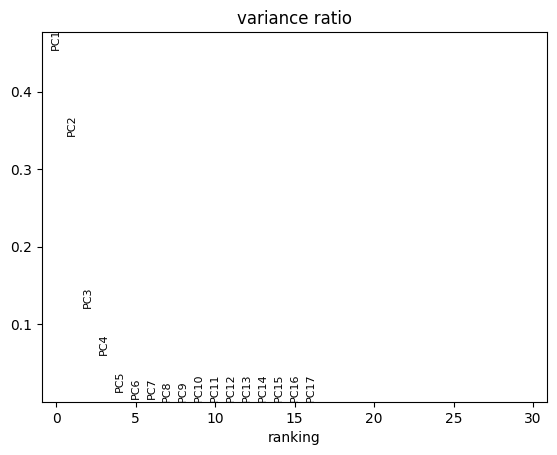

In [26]:
sc.pl.pca_overview(dds_df)

### 4) pyDESeq2 pipeline normalization and significance testing to find differentially expressed genes

In [27]:
dds_df.fit_size_factors()
dds_df.obsm["size_factors"]

dds_df.fit_genewise_dispersions()
dds_df.varm["genewise_dispersions"]

dds_df.fit_dispersion_trend()
dds_df.uns["trend_coeffs"]
dds_df.varm["fitted_dispersions"]

dds_df.fit_dispersion_prior()
print(
    f"logres_prior={dds_df.uns['_squared_logres']}, sigma_prior={dds_df.uns['prior_disp_var']}"
)

dds_df.fit_MAP_dispersions()
dds_df.varm["MAP_dispersions"]
dds_df.varm["dispersions"]

dds_df.fit_LFC()
dds_df.varm["LFC"]

dds_df.calculate_cooks()
if dds_df.refit_cooks:
    dds_df.refit()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.13 seconds.

Fitting dispersion trend curve...
... done in 4.94 seconds.

logres_prior=1.2475726829128353, sigma_prior=1.114435668218804
Fitting MAP dispersions...
... done in 3.77 seconds.

Fitting LFCs...
... done in 2.88 seconds.

Refitting 9 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.00 seconds.



In [28]:
stat_res = DeseqStats(dds_df, alpha=0.05, cooks_filter=True, independent_filter=True)

In [29]:
stat_res.run_wald_test()
stat_res.p_values

if stat_res.cooks_filter:
    stat_res._cooks_filtering()
stat_res.p_values

if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj

Running Wald tests...
... done in 2.53 seconds.



gene_1             NaN
gene_2             NaN
gene_3        0.999907
gene_4        0.999907
gene_5             NaN
                ...   
gene_20616    0.432700
gene_20617    0.069678
gene_20618    0.289898
gene_20619    0.999907
gene_20620    0.999907
Name: 23, Length: 20620, dtype: float64

In [30]:
stat_res.lfc_shrink(coeff="Condition_Exp_vs_C")

Fitting MAP LFCs...
... done in 6.82 seconds.



In [31]:
stat_res.summary()

Log2 fold change & Wald test p-value: Condition Exp vs C


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_1,0.093779,-0.006672,0.189781,-0.209768,0.833849,NaN
gene_2,0.106122,0.006596,0.420702,0.187600,0.851190,NaN
gene_3,3.621476,0.049660,0.231255,0.847015,0.396987,0.999907
gene_4,2.250522,-0.036552,0.223044,-1.014969,0.310120,0.999907
gene_5,0.351718,-0.002915,0.215223,-0.254411,0.799178,NaN
...,...,...,...,...,...,...
gene_20616,7963.864197,-0.177963,0.097155,-2.144780,0.031970,0.432700
gene_20617,18415.471338,-0.175453,0.058639,-3.080312,0.002068,0.069678
gene_20618,5465.548611,-0.157823,0.068619,-2.429119,0.015136,0.289898
gene_20619,19759.502987,-0.051697,0.118333,-0.495098,0.620531,0.999907


In [32]:
stats_sum = stat_res.results_df
stats_sum.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_1,0.093779,-0.006672,0.189781,-0.209768,0.833849,NaN
gene_2,0.106122,0.006596,0.420702,0.187600,0.851190,NaN
gene_3,3.621476,0.049660,0.231255,0.847015,0.396987,0.999907
gene_4,2.250522,-0.036552,0.223044,-1.014969,0.310120,0.999907
gene_5,0.351718,-0.002915,0.215223,-0.254411,0.799178,NaN


In [33]:
stats_sum.index

Index(['gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6', 'gene_7',
       'gene_8', 'gene_9', 'gene_10',
       ...
       'gene_20611', 'gene_20612', 'gene_20613', 'gene_20614', 'gene_20615',
       'gene_20616', 'gene_20617', 'gene_20618', 'gene_20619', 'gene_20620'],
      dtype='object', length=20620)

**use relevant info from statistical test for volcano, and identification of DE genes across samples**

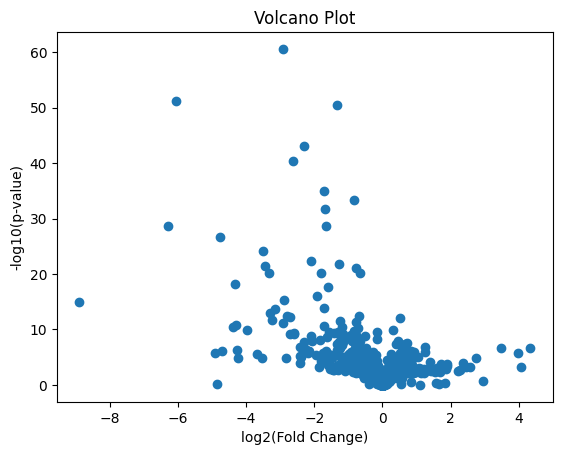

In [34]:
log2foldchange = stat_res.results_df['log2FoldChange']
pvalue = stat_res.results_df['pvalue']
padj = stat_res.results_df['padj']  

plt.scatter(log2foldchange, -np.log10(pvalue))
plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')
plt.show()

In [35]:
stats_sum['abs_log2FoldChange'] = np.abs(stats_sum['log2FoldChange'])
significance_threshold = 0.001
significant_mask = stats_sum['padj'] < significance_threshold

significant_genes = stats_sum[significant_mask]
non_significant_genes = stats_sum[~significant_mask]


**print list of top 20 differentially expressed genes across experimental conditions**

In [36]:
top_significant_genes = significant_genes.nlargest(20, 'abs_log2FoldChange')
print(top_significant_genes.index.tolist())

['gene_3932', 'gene_15522', 'gene_9171', 'gene_1747', 'gene_10166', 'gene_3340', 'gene_1661', 'gene_5584', 'gene_8117', 'gene_11892', 'gene_4345', 'gene_9170', 'gene_19303', 'gene_2323', 'gene_16307', 'gene_16524', 'gene_10921', 'gene_11858', 'gene_1659', 'gene_4344']


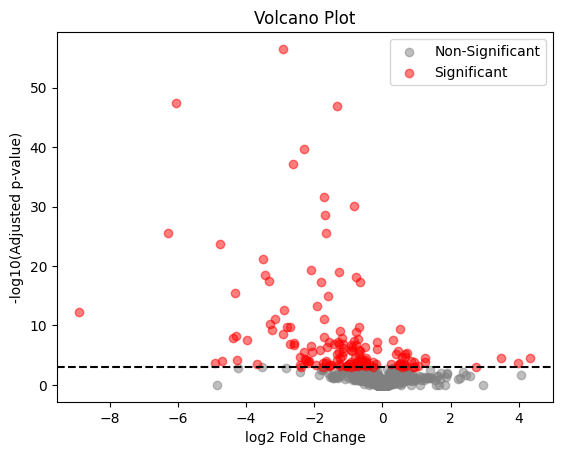

In [37]:
#non-sig genes
plt.scatter(
    non_significant_genes['log2FoldChange'],
    -np.log10(non_significant_genes['padj']),
    color='gray',
    alpha=0.5,
    label='Non-Significant')

# sig genes
plt.scatter(
    significant_genes['log2FoldChange'],
    -np.log10(significant_genes['padj']),
    color='red',
    alpha=0.5,
    label='Significant')

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(Adjusted p-value)')
plt.title('Volcano Plot')
plt.axhline(-np.log10(significance_threshold), color='black', linestyle='--')
plt.legend()
plt.show()

In [38]:
#use sanbomics mapping to return gene names from ensmbl 'Geneid'
#mapper = id_map(species = 'mouse')
#stats_sum['symbol'] = stats_sum.index.map(mapper.mapper) 
#stats_sum.head()

In [39]:
#ordering most differentially expressed to least
#ranking = stats_sum[['symbol', 'stat']].dropna().sort_values('stat', ascending = False)

### 5) GSEA plot
- in progress (not included in report)
- get gene cards from UCSD GSEA (.gmt)
- perform genome set enrichment analysis

In [ ]:
# Define the gene sets of interest (e.g., from a predefined database or custom gene sets)
#gene_sets = '/~/gene_sets/m3.all.v2023.1.Mm.entrez.gmt'  # Replace with the path to your gene sets file
#cls_labels = ['ctrl'] * 9 + ['exp'] * 9
# Perform GSEA
#gsea_results = gp.gsea(data=tpm_norm, gene_sets=gene_sets, cls = cls_labels,
                       #method='signal_to_noise', permutation_num=1000, 
                       #processes=1)  # Adjust the parameters as per your requirements


In [ ]:
# Plot the enrichment results
#gsea_results.res2d.plot.barh(title='GSEA Enrichment Results', figsize=(10, 8))
#plt.xlabel('Normalized Enrichment Score (NES)')
#plt.ylabel('Gene Set')
#plt.tight_layout()
#plt.show()